In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def plot_scaters_map(df, lon_col='lon', lat_col='lat', value_col='heat flow', color_maps=['coolwarm'], point_size=10, projection_type='robin'):
    """
    绘制全球相关性散点图的函数。
    
    参数:
    - df: 包含经纬度和相关性数据的DataFrame
    - lon_col: 表示经度的列名 (默认 'lon')
    - lat_col: 表示纬度的列名 (默认 'lat')
    - value_col: 表示相关性值的列名 (默认 'mean_ghf')
    - color_maps: 选择的配色方案列表 (默认 ['coolwarm'])
    - point_size: 散点的大小 (默认 10)
    - projection_type: Basemap投影类型 (默认 'robin')
    """
    # 提取经纬度信息和相关性值
    lon = df[lon_col]
    lat = df[lat_col]
    values = df[value_col]
    
    # 循环通过不同的配色方案绘制图表
    for cmap in color_maps:
        plt.figure(figsize=(12, 8))  # 设置图表大小
        
        # 创建 Basemap 对象，使用鲁滨逊投影
        m = Basemap(projection=projection_type, lon_0=0, resolution='c')
        
        # 画海岸线和国家边界
        m.drawcoastlines()
        m.drawcountries()
        
        # 转换经纬度为 Basemap 坐标
        x, y = m(lon.values, lat.values)
        
        # 绘制散点图，设置颜色和点大小
        sc = plt.scatter(x, y, c=values, cmap=cmap, s=point_size, label='Correlation')
        
        # 添加颜色条
        plt.colorbar(sc, label='ghf')
        
        # 添加标题和标签
        plt.title(f'Correlation Map with {value_col} using {cmap} colormap')
        plt.legend()
        
        # 显示图表
        plt.show()





In [ ]:
def distance(lat1, lon1, lat2, lon2):
    '''
    Haversine formula returns distance between pairs of coordinates.
    coordinates as numpy arrays, lists or real
    '''
    p = 0.017453292519943295 # pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742.0176 * np.arcsin(np.sqrt(a)) # returns in km


In [3]:
import pandas as pd
import numpy as np
import os

# Load the data     
all_data = pd.read_csv('World_dataset.csv')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273086 entries, 0 to 273085
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   lon                      273086 non-null  float64
 1   lat                      273086 non-null  float64
 2   Bed_Elevation            272086 non-null  float64
 3   Mean_Curvature_mean      148786 non-null  float64
 4   Sedthk                   271806 non-null  float64
 5   CurieDepth_mean          264559 non-null  float64
 6   Rocktype                 85082 non-null   float64
 7   LAB                      270276 non-null  float64
 8   Magnet_mean              265582 non-null  float64
 9   min_distance_to_volcano  273086 non-null  float64
 10  min_distance_to_hotspot  273086 non-null  float64
 11  moho_mean                272085 non-null  float64
 12  Bouguer                  273073 non-null  float64
 13  MiddleCrust              271806 non-null  float64
 14  Uppe

In [6]:
import pandas as pd
import numpy as np
from pykrige.ok import OrdinaryKriging

# 读取数据
df = pd.read_csv('World_dataset.csv')
import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator

# 读取数据


# 显示原始数据信息
print("原始数据信息：")
print(df.info())

# 定义需要插值的列（除了第6列 Rocktype 和第18列 heat flow）
columns_to_interpolate = [col for col_idx, col in enumerate(df.columns) if col_idx not in [6, 18]]

# 最近邻插值函数
def nearest_interpolation(df, column_name, lon_col='lon', lat_col='lat'):
    print(f"处理列: {column_name}")
    
    # 分离已知和缺失值的行
    known_data = df[df[column_name].notnull()]
    missing_data = df[df[column_name].isnull()]
    
    if missing_data.empty or known_data.empty:
        print(f"列 {column_name} 无需插值或数据不足")
        return df[column_name]
    
    # 已知点的经纬度和值
    coords_known = known_data[[lon_col, lat_col]].values
    values_known = known_data[column_name].values
    
    # 缺失点的经纬度
    coords_missing = missing_data[[lon_col, lat_col]].values
    
    # 创建最近邻插值模型
    interp = NearestNDInterpolator(coords_known, values_known)
    
    # 对缺失点进行插值
    interpolated_values = interp(coords_missing)
    
    # 将插值结果填回原数据
    df.loc[df[column_name].isnull(), column_name] = interpolated_values
    
    return df[column_name]

# 对需要插值的列进行最近邻插值
for col in columns_to_interpolate:
    df[col] = nearest_interpolation(df, col)

# 处理 Rocktype，将空值设为 9999
df['Rocktype'] = df['Rocktype'].fillna(9999)

# 显示处理后的数据信息
print("\n处理后的数据信息：")
print(df.info())

# 保存结果
df.to_csv('processed_World_data.csv', index=False)
print("\n数据已保存到 'processed_data.csv'")

原始数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273086 entries, 0 to 273085
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   lon                      273086 non-null  float64
 1   lat                      273086 non-null  float64
 2   Bed_Elevation            272086 non-null  float64
 3   Mean_Curvature_mean      148786 non-null  float64
 4   Sedthk                   271806 non-null  float64
 5   CurieDepth_mean          264559 non-null  float64
 6   Rocktype                 85082 non-null   float64
 7   LAB                      270276 non-null  float64
 8   Magnet_mean              265582 non-null  float64
 9   min_distance_to_volcano  273086 non-null  float64
 10  min_distance_to_hotspot  273086 non-null  float64
 11  moho_mean                272085 non-null  float64
 12  Bouguer                  273073 non-null  float64
 13  MiddleCrust              271806 non-null  float64
 

In [8]:
non_data=df.dropna(subset=['heat flow'])
non_data.to_csv('World_train_data.csv', index=False)
non_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14032 entries, 0 to 273085
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lon                      14032 non-null  float64
 1   lat                      14032 non-null  float64
 2   Bed_Elevation            14032 non-null  float64
 3   Mean_Curvature_mean      14032 non-null  float64
 4   Sedthk                   14032 non-null  float64
 5   CurieDepth_mean          14032 non-null  float64
 6   Rocktype                 14032 non-null  float64
 7   LAB                      14032 non-null  float64
 8   Magnet_mean              14032 non-null  float64
 9   min_distance_to_volcano  14032 non-null  float64
 10  min_distance_to_hotspot  14032 non-null  float64
 11  moho_mean                14032 non-null  float64
 12  Bouguer                  14032 non-null  float64
 13  MiddleCrust              14032 non-null  float64
 14  UpperCrust               1

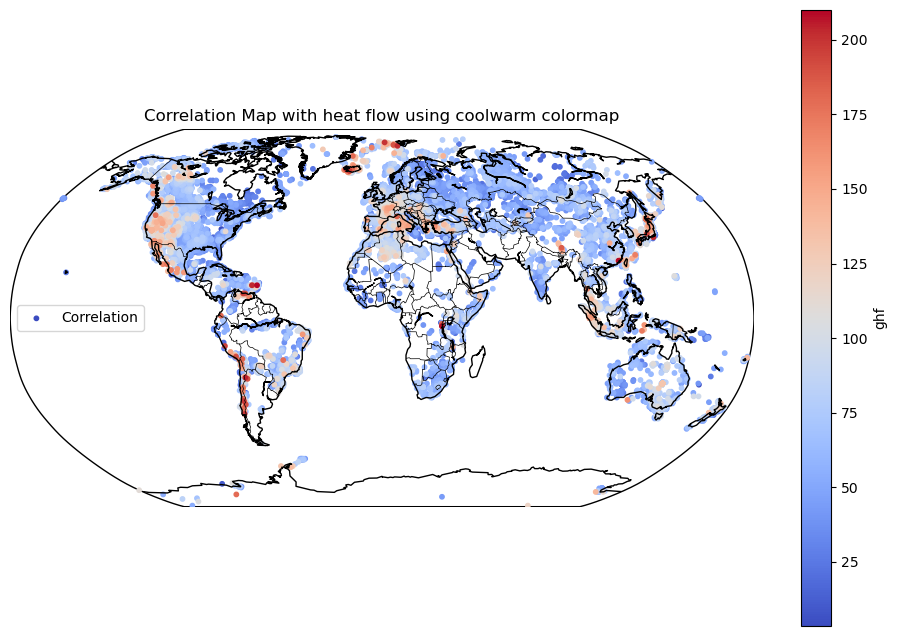

In [18]:
plot_scaters_map(non_data)

In [10]:
import pandas as pd
import numpy as np
import os

# Load the data     
Antar_data = pd.read_csv('Antarctica_dataset.csv')
Antar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78801 entries, 0 to 78800
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lon                      78801 non-null  float64
 1   lat                      78801 non-null  float64
 2   Bed_Elevation            78720 non-null  float64
 3   Mean_Curvature_mean      78720 non-null  float64
 4   Sedthk                   77920 non-null  float64
 5   CurieDepth_mean          62866 non-null  float64
 6   Rocktype                 33598 non-null  float64
 7   LAB                      76869 non-null  float64
 8   Magnet_mean              64409 non-null  float64
 9   min_distance_to_volcano  78801 non-null  float64
 10  min_distance_to_hotspot  78801 non-null  float64
 11  moho_mean                69665 non-null  float64
 12  Bouguer                  34914 non-null  float64
 13  MiddleCrust              77920 non-null  float64
 14  UpperCrust            

In [11]:
import pandas as pd
import numpy as np
from pykrige.ok import OrdinaryKriging

# 读取数据

import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator

# 读取数据


# 显示原始数据信息
print("原始数据信息：")
print(Antar_data.info())

# 定义需要插值的列（除了第6列 Rocktype 和第18列 heat flow）
columns_to_interpolate = [col for col_idx, col in enumerate(Antar_data.columns) if col_idx not in [6, 18]]

# 最近邻插值函数
def nearest_interpolation(df, column_name, lon_col='lon', lat_col='lat'):
    print(f"处理列: {column_name}")
    
    # 分离已知和缺失值的行
    known_data = df[df[column_name].notnull()]
    missing_data = df[df[column_name].isnull()]
    
    if missing_data.empty or known_data.empty:
        print(f"列 {column_name} 无需插值或数据不足")
        return df[column_name]
    
    # 已知点的经纬度和值
    coords_known = known_data[[lon_col, lat_col]].values
    values_known = known_data[column_name].values
    
    # 缺失点的经纬度
    coords_missing = missing_data[[lon_col, lat_col]].values
    
    # 创建最近邻插值模型
    interp = NearestNDInterpolator(coords_known, values_known)
    
    # 对缺失点进行插值
    interpolated_values = interp(coords_missing)
    
    # 将插值结果填回原数据
    df.loc[df[column_name].isnull(), column_name] = interpolated_values
    
    return df[column_name]

# 对需要插值的列进行最近邻插值
for col in columns_to_interpolate:
    Antar_data[col] = nearest_interpolation(Antar_data, col)

# 处理 Rocktype，将空值设为 9999
Antar_data['Rocktype'] = Antar_data['Rocktype'].fillna(16)

# 显示处理后的数据信息
print("\n处理后的数据信息：")
print(Antar_data.info())

# 保存结果
Antar_data.to_csv('processed_Antar_data.csv', index=False)
print("\n数据已保存到 'processed_data.csv'")

原始数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78801 entries, 0 to 78800
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lon                      78801 non-null  float64
 1   lat                      78801 non-null  float64
 2   Bed_Elevation            78720 non-null  float64
 3   Mean_Curvature_mean      78720 non-null  float64
 4   Sedthk                   77920 non-null  float64
 5   CurieDepth_mean          62866 non-null  float64
 6   Rocktype                 33598 non-null  float64
 7   LAB                      76869 non-null  float64
 8   Magnet_mean              64409 non-null  float64
 9   min_distance_to_volcano  78801 non-null  float64
 10  min_distance_to_hotspot  78801 non-null  float64
 11  moho_mean                69665 non-null  float64
 12  Bouguer                  34914 non-null  float64
 13  MiddleCrust              77920 non-null  float64
 14  UpperCrust    

In [12]:
#Antar_data=Antar_data.dropna(subset=['heat flow_mean'])
Antar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78801 entries, 0 to 78800
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lon                      78801 non-null  float64
 1   lat                      78801 non-null  float64
 2   Bed_Elevation            78801 non-null  float64
 3   Mean_Curvature_mean      78801 non-null  float64
 4   Sedthk                   78801 non-null  float64
 5   CurieDepth_mean          78801 non-null  float64
 6   Rocktype                 78801 non-null  float64
 7   LAB                      78801 non-null  float64
 8   Magnet_mean              78801 non-null  float64
 9   min_distance_to_volcano  78801 non-null  float64
 10  min_distance_to_hotspot  78801 non-null  float64
 11  moho_mean                78801 non-null  float64
 12  Bouguer                  78801 non-null  float64
 13  MiddleCrust              78801 non-null  float64
 14  UpperCrust            